# Use Trained Model

Let's load the trained model and see how it performs on the CIFAR-10 Dataset.

In [1]:
import torch
import torchvision
import tensorwatch as tw
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from random import choice

from cifar import initialize_dataloaders, initialize_model

USE_CUDA = torch.cuda.is_available()

## Visualizing CIFAR-10 Dataset
What kinds of images are in the CIFAR-10 Dataset?

In [2]:

label_names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse",
               "ship", "truck")
               
num_classes, trainloader, testloader = initialize_dataloaders(
    "cifar10", train_batch=1, test_batch=100)

def show_img(grid_img):
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)

    # unnormalize the data
    for channel in range(3):
        grid_img[channel] = (grid_img[channel] * std[channel]) + mean[channel]

    # np_grid is currently [channel, height, width]
    np_grid = grid_img.numpy()
    # convert to [height, width, channel]
    transposed_np_grid = np.transpose(np_grid, (1, 2, 0))

    plt.imshow(transposed_np_grid)
    plt.show()


Files already downloaded and verified


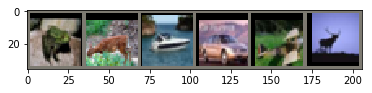

['frog', 'deer', 'ship', 'car', 'plane', 'deer']


In [4]:
num_images_to_show = 6

images_to_show = []
corresponding_labels = []

for i in range(num_images_to_show):
    images, labels = iter(trainloader).next()
    images_to_show.append(images[0])
    corresponding_labels.append(label_names[labels[0]])

grid_img = torchvision.utils.make_grid(images_to_show)
show_img(grid_img)
print(corresponding_labels)

## Observing our Model Outputs
The following blocks load our trained model and execute the model on our given images.

In [6]:
# PATH = "checkpoints/cifar10/alexnet/1/checkpoint.pth.tar"
PATH = "checkpoints/bonnie/0/model_best.pth.tar"

checkpoint = torch.load(PATH)
model = initialize_model("alexnet", 10)
model = torch.nn.DataParallel(model)

model.load_state_dict(checkpoint["state_dict"])

print("Loaded model from epoch {}, test acc: {}, best test acc: {}".format(
checkpoint["epoch"], checkpoint["acc"], checkpoint["best_acc"]))


Loaded model from epoch 124, test acc: 77.49, best test acc: 77.49


In [8]:
# Calculate performance on all test data
prediction_output = {}
mistakes = []
df_dict = {
    "y_actual": [],
    "y_pred": []
}

for batch_idx, (inputs, targets) in enumerate(testloader):
    if USE_CUDA:
        inputs, targets = inputs.cuda(), targets.cuda()
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    for label_idx, _ in enumerate(targets):
        correct = targets[label_idx].item() == predicted[label_idx].item()

        true_label = label_names[targets[label_idx].item()]
        pred_label = label_names[predicted[label_idx].item()]
        df_dict["y_actual"].append(true_label)
        df_dict["y_pred"].append(pred_label)
        
        prediction_output[true_label] = prediction_output.get(true_label, [])
        prediction_output[true_label].append(correct)
        if not correct:
            mistakes.append((inputs[label_idx], true_label, pred_label))        


cat:	582/1000 (58.20%)
ship:	858/1000 (85.80%)
plane:	833/1000 (83.30%)
frog:	841/1000 (84.10%)
car:	869/1000 (86.90%)
truck:	819/1000 (81.90%)
dog:	686/1000 (68.60%)
horse:	815/1000 (81.50%)
deer:	742/1000 (74.20%)
bird:	704/1000 (70.40%)

cumulative results:	7749/10000 (77.49%)


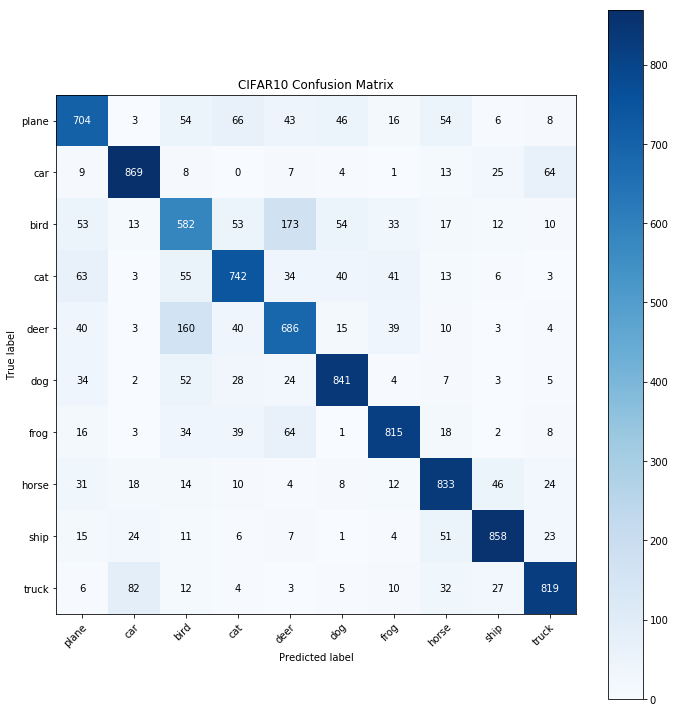

In [9]:
# For each of the labels, what is the corresponding prediction accuracy?
cumulative_ok = 0
cumulative_total = 0
for k, v in prediction_output.items():
    print("{}:\t{}/{} ({:.2f}%)".format(k, sum(v), len(v), sum(v)/len(v) * 100))
    cumulative_ok += sum(v)
    cumulative_total += len(v)

print("\ncumulative results:\t{}/{} ({:.2f}%)".format(
    cumulative_ok, cumulative_total, cumulative_ok/cumulative_total * 100))
    
# Generate Confusion Matrix
normalize = False

cm = confusion_matrix(df_dict["y_actual"], df_dict["y_pred"])
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# show all ticks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=label_names, yticklabels=label_names,
       title="CIFAR10 Confusion Matrix",
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

## What mistakes did the neural network make?

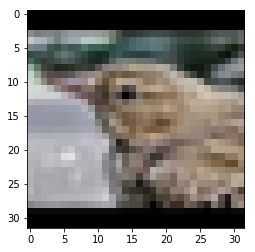

Predicted: deer, Actual: bird


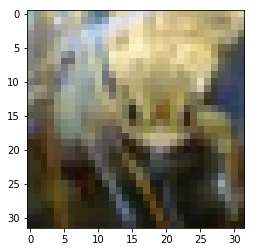

Predicted: dog, Actual: frog


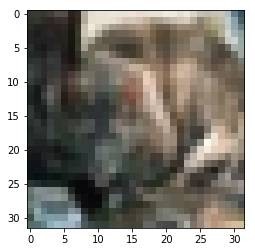

Predicted: dog, Actual: cat


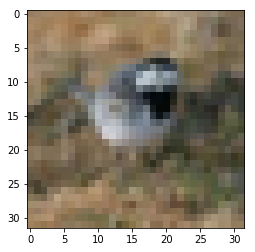

Predicted: frog, Actual: bird


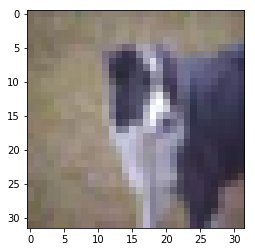

Predicted: cat, Actual: dog


In [11]:
for i in range(5):
    img_tensor, true_label, predicted_label = choice(mistakes)
    show_img(img_tensor.cpu())
    print("Predicted: {}, Actual: {}".format(predicted_label, true_label))
